In [1]:
import mujoco, mujoco.renderer, mujoco.viewer
import mediapy as media
import numpy as np
import matplotlib.pyplot as plt

xml = """
<mujoco>
  <visual>
    <quality offsamples="0"/>
    <global offwidth="680" offheight="420"/>
  </visual>

  <worldbody>

    <geom name="floor" type="plane" size="2 2 0.1" rgba="0.9 0.9 0.9 1"/>

    <geom name="box" type="box" pos="0 0 0.3" size="0.2 0.2 0.2" quat="-0.82 -0.42 0.17 0.35" rgba="0.9 0.1 0.1 1"/>

    <camera name="camera2" pos="-0.8 -0.8 1" quat="-0.82 -0.42 0.17 0.35" />

  </worldbody>
</mujoco>

"""

m = mujoco.MjModel.from_xml_string(xml)
d = mujoco.MjData(m)

depth_renderer = mujoco.Renderer(m, 420, 680); depth_renderer.enable_depth_rendering()
sgmnt_renderer = mujoco.Renderer(m, 420, 680); sgmnt_renderer.enable_segmentation_rendering()

# Step and render
mujoco.mj_step(m, d)

depth_renderer.update_scene(d, 0)
sgmnt_renderer.update_scene(d, 0)

In [2]:
def get_point_cloud(frame, sgmnt, w, h):
    fovy = 60
    f_y = 0.5 * h / np.tan(fovy * np.pi / 360)
    f_x = f_y * (w / h)

    # Create arrays for x and y coordinates
    x = (np.arange(0, w) - w/2) * w / h / f_x
    y = (np.arange(0, h) - h/2) / f_y
    z = np.ones((w*h, 1))
    
    # Use meshgrid to create two grids of x and y coordinates
    X, Y = np.meshgrid(x, y)

    # Stack X and Y to create the matrix
    matrix = np.vstack((X.flatten(), Y.flatten())).T

    # Vectorized matrix to convert depth to 3D points
    matrix = np.concatenate((matrix, z), axis=1)

    frame = frame.reshape((-1, 1))
    sgment = sgmnt.reshape((-1, 1))

     # Get the points in the frame
    points = frame * matrix

    # Selecting renders 
    sgment = sgment[~np.isnan(points).any(axis=1)]
    points = points[~np.isnan(points).any(axis=1)]

    return points, sgment

In [3]:
def zoom(array, a, b, top_left_row, top_left_col):
  """
  Get a sub array in the middle of the given array, starting at the top left pixel
  index.

  Args:
    array: A numpy array of size n x m.
    a: The height of the sub array.
    b: The width of the sub array.
    top_left_row: The row index of the top left pixel of the sub array.
    top_left_col: The column index of the top left pixel of the sub array.

  Returns:
    A numpy array of size a x b.
  """

  n, m = array.shape
  start_row = top_left_row
  start_col = top_left_col
  end_row = start_row + a
  end_col = start_col + b
  sub_array = array[start_row:end_row, start_col:end_col]
  return sub_array

(420, 680)


""

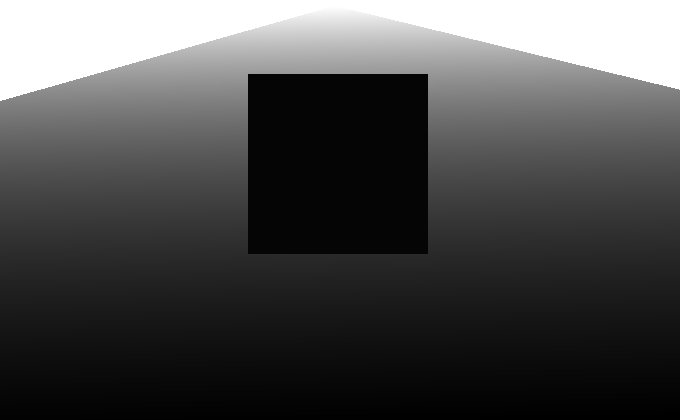

(420, 680)


""

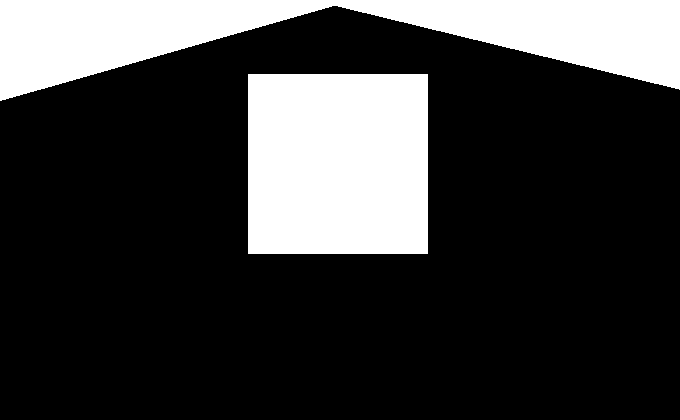

In [4]:
depth = depth_renderer.render()
sgmnt = sgmnt_renderer.render()[:, :, 0].astype("float")

depth[depth > 4] = np.nan
sgmnt[sgmnt == -1] = np.nan

# depth[85, 320] = 5
# sgmnt[85, 320] = 3

print(depth.shape)
media.show_image(depth)
print(sgmnt.shape)
media.show_image(sgmnt)

In [5]:
z_depth = zoom(depth, 20, 20, 85, 320)
z_sgmnt = zoom(sgmnt, 20, 20, 85, 320)

print(z_depth.shape)
media.show_image(z_depth)
print(z_sgmnt.shape)
media.show_image(z_sgmnt)

(20, 20)


""


(20, 20)


""


<Figure size 640x480 with 0 Axes>

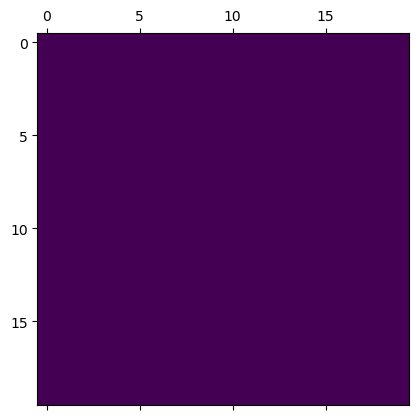

In [6]:
fig = plt.figure()
plt.matshow(z_depth)

<Figure size 640x480 with 0 Axes>

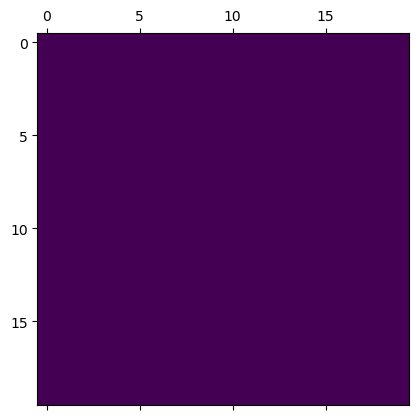

In [7]:
fig = plt.figure()
plt.matshow(z_sgmnt)

In [8]:
import open3d as o3d

pc, ids = get_point_cloud(depth, sgmnt, 680, 420)

print(pc.shape)
print(ids.shape)

pcd = o3d.geometry.PointCloud()

for id in np.unique(ids):
    pcd.points = o3d.utility.Vector3dVector(pc[(ids == id).any(axis=1)])
    o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(251214, 3)
(251214, 1)


In [ ]:
import mujoco, mujoco.renderer, mujoco.viewer
import numpy as np
import open3d as o3d
xml = """
<mujoco>
  <visual>
    <global offwidth="680" offheight="420"/>
  </visual>

  <worldbody>

    <geom name="floor" type="plane" size="2 2 0.1" rgba="0.9 0.9 0.9 1"/>

    <geom name="box" type="box" pos="0 0 0.2" size="0.2 0.2 0.2" rgba="0.9 0.1 0.1 1"/>

    <camera name="camera2" pos="-0.8 -0.8 1" quat="-0.82 -0.42 0.17 0.35" />

  </worldbody>
</mujoco>

"""

# Creating model and data
m = mujoco.MjModel.from_xml_string(xml)
d = mujoco.MjData(m)

# Creating the renderers
depth_renderer = mujoco.Renderer(m, 420, 680); depth_renderer.enable_depth_rendering()
sgmnt_renderer = mujoco.Renderer(m, 420, 680); sgmnt_renderer.enable_segmentation_rendering()

# Step and render
mujoco.mj_step(m, d)

depth_renderer.update_scene(d, 0)
sgmnt_renderer.update_scene(d, 0)

# Rendering depth and segmentation frames
depth = depth_renderer.render()
sgmnt = sgmnt_renderer.render()[:, :, 0].astype("float")

depth[depth > 4] = np.nan
sgmnt[sgmnt == -1] = np.nan

# Generating point clouds
point_cloud, ids = get_point_cloud(depth, sgmnt, 680, 420)

# Displaying point clouds
pcd = o3d.geometry.PointCloud()
for id in np.unique(ids):
    pcd.points = o3d.utility.Vector3dVector(point_cloud[(ids == id).any(axis=1)])
    o3d.visualization.draw_geometries([pcd])
